# Parameter Sweeps - Second Attempt

In [1]:
import datetime
import warnings
import itertools as it
import time

import dill
from arctic.exceptions import NoDataFoundException
from arctic import Arctic

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from sympy import divisors

import ipyparallel as ipp
import ipywidgets as ipw
import ipyvolume as ipv
import qgrid

## View

In [2]:
def param_grid(**kwargs):
    """Generate Cartesian product of keyword arguments"""
    prod = it.product(kwargs.items())
    name_list, values_list = zip(*kwargs.items())
    value_combinations = list(it.product(*values_list))
    return name_list, value_combinations

def param_df(**kwargs):
    """Generate pandas DataFrame from Cartesian product of keyword arguments"""
    names, values = param_grid(**kwargs)
    return pd.DataFrame(values, columns=names)

def param_qgrid(qgrid_layout=None, **kwargs):
    """Generate Qgrid table from Cartesian product of keyword arguments"""
    if not qgrid_layout:
        qgrid_layout=ipw.Layout()
    return qgrid.QgridWidget(df=param_df(**kwargs), layout=qgrid_layout)

def dict_list_from_df(df):
    """Turn each row into a dictionary indexed by column names"""
    return [{col: val for col, val in zip(df.columns, df.loc[ind,:])} for ind in df.index]

In [3]:
class ParamSpanRemoteConfig(object):
    def __init__(self):
        self.init_db()
        self.init_engines()
    
    def init_db(self):
        # Collect database info
        db_host = 'localhost'
        db_port = 27017
        lib_name = 'kale-param-spans'
        self.store = Arctic('mongodb://{}:{}'.format(db_host, db_port))
        self.store.initialize_library(lib_name)
        self.library = self.store[lib_name]

        # Package database info to send to engines
        self.db_info = [
            db_host,
            db_port,
            lib_name
        ]

    def init_engines(self):
        # Connect to controller
        with warnings.catch_warnings():
            warnings.simplefilter("ignore")
            self.ipp_client = ipp.Client()

        # Establish views
        self.dview = self.ipp_client.direct_view()
        self.lview = self.ipp_client.load_balanced_view()
            
        # Tell engines their ids
        for i, engine in enumerate(self.ipp_client):
            engine.push({'engine_id': i})
            
        # Distribute database information
        self.dview.push({'db_info': self.db_info})
        
        def load_library():
            global store, library
            from arctic import Arctic
            db_host, db_port, lib_name = db_info
            store = Arctic('mongodb://{}:{}'.format(db_host, db_port))
            library = store[lib_name]
        self.dview.apply(load_library)

In [4]:
class ParamSpanWidget(ipw.VBox):
    def __init__(self, param_span_name, remote_config, compute_func, vis_func, output_layout=None, qgrid_layout=None):
        self.compute_func = compute_func
        self.name = param_span_name
        self.remote_config = remote_config
        self.vis_func = vis_func
        self.output_layout = output_layout
        self.qgrid_layout = qgrid_layout

        super().__init__()

        self.load_remote_config()
        self.init_widgets()
        self.init_layout()

    def load_remote_config(self):
        self.ipp_client = self.remote_config.ipp_client
        self.dview = self.remote_config.dview
        self.lview = self.remote_config.lview
        self.db_info = self.remote_config.db_info
        self.store = self.remote_config.store
        self.library = self.remote_config.library
        self.lview = self.remote_config.lview
        
    def init_widgets(self):
        if not self.output_layout:
            self.output_layout = ipw.Layout(height='500px', border='1px solid', overflow_x='scroll', overflow_y='scroll')
        if not self.qgrid_layout:
            qgrid_layout = ipw.Layout()

        self.output = ipw.Output(layout=self.output_layout)
        # param_table is empty until set_params is called
        self.param_table = param_qgrid(self.qgrid_layout, **{'':[]})

    def init_logic(self):
        self.param_table.observe(self.visualize_wrapper, names='_selected_rows')

    def init_layout(self):
        self.children = [
            self.output,
            self.param_table
        ]

    def set_params(self, **all_params):
        """Provide parameter set to search over
        all_params = {
            'param1': [val1, val2, ...],
            'param2': [val3, val4, ...],
            ...
        }
        """
        self.param_table = param_qgrid(self.qgrid_layout, **all_params)
        self.init_logic()
        self.init_layout()

    def submit_computations(self, *change):
        def compute_wrapper(compute_func, name, paramset_id, params, library):
            """Perform computation and send results to MongoDB for one set of params"""
            results = compute_func(**params)
            
            # Index collection by paramset_id and paramspan name
            record_label = '{}-{}'.format(name, paramset_id)
            library.write(
                record_label,
                results
            )

        # Loop over all sets of parameters
        # paramset_id is the row index,
        # paramset is the dictionary of params
        self.compute_futures = []
        for paramset_id, paramset in self.param_table.df.T.to_dict().items():
            # Submit task to IPyParallel
            fut =  self.lview.apply(compute_wrapper, self.compute_func, self.name, paramset_id, paramset, self.library)
            self.compute_futures.append(fut)

    def visualize_wrapper(self, *change):
        """Call visualization function and capture output"""
        # Do nothing if selection is empty:
        # Empty list evaluates to False
        if not self.param_table.get_selected_rows():
            return

        # Get params from selected row (take first row if >1 selected)
        # The ordering is not necessarily the same as in widget,
        # so weird things might happen if multiple rows are selected.
        paramset_id = self.param_table.get_selected_df().index[0]
        paramset = self.param_table.df.loc[paramset_id, :]

        # Search collection by parameters
        record_label = '{}-{}'.format(self.name, paramset_id)
        # Clear screen if the results of this computation
        # are not available. Assume empty dict by default
        compute_results = {}
        try:
            compute_results = self.library.read(record_label).data
        except NoDataFoundException:
            self.output.clear_output()

        # Avoid using output context to ensure that
        # only this function's output is included.
        @self.output.capture(clear_output=True, wait=True)
        def wrapper():
            self.vis_func(**compute_results)
        wrapper()
        
    def get_entries(self):
        """Get all results stored in database from parameter spans with this name"""
        return [entry for entry in self.library.list_symbols() if entry[:len(self.name)+1] == self.name+'-']
       
    def delete_results(self):
        """This will delete all results from parameter spans with this name!"""
        for entry in self.get_entries():
            self.library.delete(entry)

In [5]:
remote_config = ParamSpanRemoteConfig()

Library created, but couldn't enable sharding: no such command: 'enablesharding', bad cmd: '{ enablesharding: "arctic", lsid: { id: UUID("e77f32a2-024d-4079-bee7-b31776028bf5") }, $readPreference: { mode: "secondaryPreferred" }, $db: "admin" }'. This is OK if you're not 'admin'


# User functions

In [6]:
def exp_compute(N, mean, std, color):
    import numpy as np
    from datetime import datetime
    x = np.random.normal(loc=mean, scale=std, size=N)
    realmean = np.mean(x)
    realstd = np.std(x)
    return {
        'engine_id': engine_id,
        'date': datetime.now().ctime(),
        'x': x,
        'N': N,
        'realmean': realmean,
        'realstd': realstd,
        'color': color
    }
    
def exp_viz(engine_id, date, x, N, realmean, realstd, color):
    print("Computed on engine {} at {}".format(engine_id, date))
    plt.figure(figsize=[8,5])
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        sns.distplot(x, color=color)
    plt.title(r'$N={}$, $\mu={:.2f}$, $\sigma={:.2f}$'.format(N, realmean, realstd))
    plt.show()
    print("Data: {}".format(x))

In [7]:
import kelp3d_objs as k3

In [8]:
# Variable parameters
# Grid search over cartesian product
# TODO: Find reasonable values for a_water and b
a_water = [5.0, ]#0.1, 1.0, 10.0] # (%/m)
b = [0.0, 0.1, ]#1.0, 10.0] # (%/m)
# Number of x & y grid cells
ns = [4, 6, 8, ]#12, 24] # (#), all must be factors of largest to avoid interpolation
# Number of angular grid cells (Same for theta & phi)
na = [4, 6, 8, ]#12, 24] # (#), same note as above, but cannot be odd.

In [9]:
# Hard-coded parameters
absorptance_kelp = 0.8 # (%)
rope_spacing = 5.0 # (m)
zmin, zmax = 0.0, 1.0 # (m)
nz=10

# Light from above
I0 = 10.0 # (W/m^2)
phi_s = 0 # (rad)
theta_s = 0 # (rad)
decay = 10 # (?) - light (practically) only from directly above

# Calculated or otherwise boring parameters
xmin = -rope_spacing/2
xmax = rope_spacing/2
ymin = -rope_spacing/2
ymax = rope_spacing/2

# Solver parameters
num_scatters = 2
gmres_flag = False
tol_abs = 1e-6
tol_rel = 1e-6
maxiter_inner = 50
maxiter_outer = 50
gmres_wrapper = k3.gmres_wrapper

const = (rope_spacing, zmin, zmax, nz, I0, phi_s, theta_s, decay, xmin, xmax, ymin, ymax, absorptance_kelp,
         num_scatters, gmres_flag, tol_abs, tol_rel, maxiter_inner, maxiter_outer, gmres_flag, gmres_wrapper)

In [10]:
def nokelp_calculate(a_water, b, ns, na, const, num_threads=1):
    from kelp3d_objs import f90
    import numpy as np
    from datetime import datetime
    import time
    
    # Extract constants
    (rope_spacing, zmin, zmax, nz, I0, phi_s, theta_s, decay, xmin, xmax, ymin, ymax, absortpance_kelp,
         num_scatters, gmres_flag, tol_abs, tol_rel, maxiter_inner, maxiter_outer, gmres_flag, gmres_wrapper) = const
    a_kelp = a_water
    
    num_vsf = na
    vsf_angles = np.linspace(0,np.pi, na)
    vsf_vals = 0*vsf_angles + 1/(4*np.pi)
    ns = int(ns)
    
    nomega = int(na*(na-2)+2)
    p_kelp = np.asfortranarray(np.zeros([ns,ns,nz]))
    radiance = np.asfortranarray(np.zeros([ns, ns, nz, nomega]))
    irradiance = np.asfortranarray(np.zeros([ns, ns, nz]))
    
    # Start timer
    tic = time.time()
    
    # Calculate light field
    f90.calculate_light_field(
        xmin, xmax,
        ymin, ymax,
        zmin, zmax,
        na, na,
        a_water, a_kelp, b,
        vsf_angles, vsf_vals,
        theta_s, phi_s, I0, decay,
        tol_abs, tol_rel, maxiter_inner, maxiter_outer,
        p_kelp, radiance, irradiance,
        num_scatters, gmres_flag, gmres_wrapper,
    )
    
    # End timer
    toc = time.time()
    date = datetime.now().ctime()
    
    return {
        'duration': toc - tic,
        'date': date,
        'radiance': radiance,
        'irradiance': irradiance
    }

In [11]:
def nokelp_visualize(duration, date, radiance, irradiance):
    print("Computation finished {}".format(date))
    print("Took {:.2f} seconds".format(duration))
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        fig = ipv.figure()
        ipv.volshow(irradiance.T, controls=False)
    
    # Set initial angle
    fig.anglex = 0.85 * np.pi
    fig.angley = -0.30 * np.pi
    fig.anglez = -0.67 * np.pi
    ipv.show()

In [27]:
def kelp_calculate(a_water, b, ns, na, kelp_profile, const, num_threads=1):
    from kelp3d_objs import f90
    import numpy as np
    from datetime import datetime
    import time
    
    # Extract constants
    (rope_spacing, zmin, zmax, nz, I0, phi_s, theta_s, decay, xmin, xmax, ymin, ymax, absorptance_kelp,
         num_scatters, gmres_flag, tol_abs, tol_rel, maxiter_inner, maxiter_outer, gmres_flag, gmres_wrapper) = const
    
    dz = (zmax-zmin)/nz
    print("dz = {}".format(dz))
    
    num_vsf = na
    vsf_angles = np.linspace(0,np.pi, na)
    vsf_vals = 0*vsf_angles + 1/(4*np.pi)
    ns = int(ns)
    
    nomega = int(na*(na-2)+2)
    p_kelp = np.asfortranarray(np.zeros([ns,ns,nz]))
    radiance = np.asfortranarray(np.zeros([ns, ns, nz, nomega]))
    irradiance = np.asfortranarray(np.zeros([ns, ns, nz]))
    
    # z grid centers
    z = np.linspace(zmin+0.5*dz, zmax-0.5*dz, nz)
    
    # Start timer
    tic = time.time()
    
    
    # Kelp distribution profiles
    frond_length_funcs = {
        'top-heavy': 2.0 * (1-z)**2 * np.exp(z),
        'bottom-heavy': 2.0 * z**2 * np.exp(1-z),
        'uniform': 0*z + 2.5,
        'none': 0*z
    }
    
    # Top-heavy
    frond_lengths = frond_length_funcs[kelp_profile]
    #frond_lengths = np.ones(nz)
    frond_stds = 0.0 * np.ones(nz)
    num_fronds = 10 * np.ones(nz)
    water_speeds = 0.5 * np.ones(nz)
    water_angles = 2*np.pi / zmax * (z-zmin)
    
    fs = 0.5
    fr = 0.5
    ft = 1e-2
    
    print("theoretical max_kelp = {}".format(num_fronds.max()*ft/dz))
    
    a_kelp = absorptance_kelp / ft
    
    # Generate kelp
    f90.gen_kelp(
        xmin, xmax,
        ymin, ymax,
        zmin, zmax,
        frond_lengths,
        frond_stds,
        num_fronds,
        water_speeds,
        water_angles,
        fs, fr, ft,
        p_kelp
    )
    
    print("Max kelp = {}".format(p_kelp.max()))
    
    # Calculate light field
    f90.calculate_light_field(
        xmin, xmax,
        ymin, ymax,
        zmin, zmax,
        na, na,
        a_water, a_kelp, b,
        vsf_angles, vsf_vals,
        theta_s, phi_s, I0, decay,
        tol_abs, tol_rel, maxiter_inner, maxiter_outer,
        p_kelp, radiance, irradiance,
        num_scatters, gmres_flag, gmres_wrapper,
    )
    
    # End timer
    toc = time.time()
    date = datetime.now().ctime()
    
    return {
        'duration': toc - tic,
        'date': date,
        'radiance': radiance,
        'irradiance': irradiance,
        'p_kelp': p_kelp
    }

In [28]:
def kelp_visualize(duration, date, radiance, irradiance, p_kelp):
    print("Computation finished {}".format(date))
    print("Took {:.2f} seconds".format(duration))
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        kelpfig = ipv.figure()
        ipv.volshow(p_kelp.T, controls=False)
        # set initial angle
        kelpfig.anglex = 0.85 * np.pi
        kelpfig.angley = -0.30 * np.pi
        kelpfig.anglez = -0.67 * np.pi
        
        irradfig = ipv.figure()
        ipv.volshow(irradiance.T, controls=False)
        # set initial angle
        irradfig.anglex = 0.85 * np.pi
        irradfig.angley = -0.30 * np.pi
        irradfig.anglez = -0.67 * np.pi
        
        
    rad_text = "Rad Stats<br>---------<br>min: {:.3e}<br>max: {:.3e}<br>mean: {:.3e}<br>std: {:.3e}".format(
        radiance.min(),
        radiance.max(),
        radiance.mean(),
        radiance.std()
    )
        
    irrad_text = "Irrad Stats<br>-----------<br>min: {:.3e}<br>max: {:.3e}<br>mean: {:.3e}<br>std: {:.3e}".format(
        irradiance.min(),
        irradiance.max(),
        irradiance.mean(),
        irradiance.std()
    )
        
    display(ipw.HBox([
        kelpfig, 
        irradfig,
        ipw.Box(layout=ipw.Layout(width='10px')),
        ipw.HTML("<tt>{}<br><br>{}</tt>".format(rad_text, irrad_text))
    ]))


In [43]:
# Hard-coded parameters
absorptance_kelp = 0.8 # (%)
rope_spacing = 5.0 # (m)
zmin, zmax = 0.0, 1.0 # (m)
nz=10

# Light from above
I0 = 10.0 # (W/m^2)
phi_s = 0 # (rad)
theta_s = 0 # (rad)
decay = 0 # (?) - light (practically) only from directly above

# Calculated or otherwise boring parameters
xmin = -rope_spacing/2
xmax = rope_spacing/2
ymin = -rope_spacing/2
ymax = rope_spacing/2

# Solver parameters
num_scatters = 0
gmres_flag = True
tol_abs = 1e-6
tol_rel = 1e-6
maxiter_inner = 50
maxiter_outer = 50
gmres_wrapper = k3.gmres_wrapper

const = (rope_spacing, zmin, zmax, nz, I0, phi_s, theta_s, decay, xmin, xmax, ymin, ymax, absorptance_kelp,
         num_scatters, gmres_flag, tol_abs, tol_rel, maxiter_inner, maxiter_outer, gmres_flag, gmres_wrapper)

In [31]:
psw = ParamSpanWidget('kelp', remote_config, kelp_calculate, kelp_visualize)
psw.set_params(
    a_water = [1.0],
    b = [0.5],#, 0.7],
    # Number of x & y grid cells
    ns = [10],
    # Number of angular grid cells (Same for theta & phi)
    na = [6, 8, 10, 12, 14, 18, 20, 24],
    #na = [10, 12, 14, 18],
    kelp_profile = ['bottom-heavy'],# 'bottom-heavy', 'uniform'],
    const=[const]
)
psw.submit_computations()
psw

ParamSpanWidget(children=(Output(layout=Layout(border='1px solid', height='500px', overflow_x='scroll', overfl…

In [32]:
def block_mean(large_arr, small_shape):
    """Calculate an array of block means of `large_arr` which has the shape `small_shape`"""

    if all(n_large % n_small == 0 for n_small, n_large in zip(small_shape, large_arr.shape)):
        # Try to abstract over number of dimensions
        avg = np.zeros(small_shape)
        block_sizes = [n_large // n_small for n_small, n_large in zip(small_shape, large_arr.shape)]
        #print("block_sizes = {}".format(block_sizes))

        # Loop over all combinations of indices
        for inds in it.product(*(range(n) for n in small_shape)):
            #print("inds = {}".format(inds))
            startinds = [ind * block_size for ind, block_size in zip(inds, block_sizes)]
            stopinds = [(ind+1) * block_size for ind, block_size in zip(inds, block_sizes)]
            slices = tuple(slice(startind, stopind) for startind, stopind in zip(startinds, stopinds))
            #print("startinds = {}".format(startinds))
            #print("stopinds = {}".format(stopinds))
            avg[inds] = large_arr[slices].mean()

        return avg
    
    else:
        raise IndexError("`small_shape` must divide `large_arr.shape` elementwise.")

In [33]:
def grid_study(max_ns, max_na, const, min_ns=4, min_na=4):
    # Determine which grid sizes to run.
    # Must be a factor of maximum,
    # and na must be even.
    ns_list = [n for n in divisors(max_ns) if n >= min_ns]
    na_list = [n for n in divisors(max_na) if n >= min_na and n%2 == 0]
    
    # Create parameter span
    param_span_name = 'kelp-grid-study'
    psw = ParamSpanWidget(param_span_name, remote_config, kelp_calculate, kelp_visualize)
    
    # Extra parameters
    a_kelp = [10.0]
    a_water = [1.0]
    b = [0.3]
    kelp_profile = ['top-heavy']
    
    # DELETE PREVIOUS RESULTS UNDER THIS NAME
    psw.delete_results()
    
    # Set parameters
    psw.set_params(
        ns = ns_list,
        na = na_list,
        a_water = a_water,
        b = b,
        kelp_profile = kelp_profile,
        const=[const]
    )
    
    # Run computations
    psw.submit_computations()
    
    # Wait for computations to complete
    for fut in psw.compute_futures:
        fut.wait()
    
    # Allocate error arrays
    abs_err = np.zeros([len(ns_list), len(na_list)])
    rel_err = np.zeros([len(ns_list), len(na_list)])
    
    #grid_sizes = np.empty([len(ns_list), len(na_list)], dtype=object)
    #ns_grid, na_grid = np.meshgrid(ns_list, na_list, indexing='ij')
    
    # Extract "true" (highest accuracy) radiance
    # Assume that highest index is highest solution
    # (jobs were submitted in order of increasing grid size)
    true_ind = len(ns_list) * len(na_list) - 1
    true_irrad = psw.library.read('{}-{}'.format(param_span_name, true_ind)).data['irradiance']
    
    # Compare values
    for i, ns in enumerate(ns_list):
        for j, na in enumerate(na_list):
            # Find the index of this combination
            # Assuming only one row matches both ns and na.
            ind = psw.param_table.df.query('ns == {} and na == {}'.format(ns, na)).index[0]
            
            # Read radiance
            irrad = psw.library.read('{}-{}'.format(param_span_name, ind)).data['irradiance']
            
            #print("i, ns = {}".format((i, ns)))
            #print("j, na = {}".format((j, na)))
            #print("irrad shape = {}".format(irrad.shape))
            #print("true_irrad shape = {}".format(true_irrad.shape))
            
            # Block averages of true radiance
            avg_true = block_mean(true_irrad, irrad.shape)
            
            # Calculate error
            abs_err[i, j] = np.mean(np.abs(irrad-avg_true))
            rel_err[i, j] = np.mean(np.abs(irrad-avg_true)/np.abs(avg_true))
    
    return psw, ns_list, na_list, abs_err, rel_err


In [ ]:
gs, ns_list, na_list, abs_err, rel_err = grid_study(max_ns=24, max_na=24, const=const)
gs

In [36]:
ns_list

[4, 6, 8, 12, 24]

In [37]:
na_list

[4, 6, 8, 12, 24]

In [38]:
abs_err

array([[5.38708559, 3.48849013, 3.05514392, 2.78778868, 2.68291327],
       [3.00775731, 1.40043576, 1.05965096, 0.74671997, 0.64690987],
       [2.36398069, 1.01068296, 0.72078053, 0.53660416, 0.47259918],
       [2.47867825, 0.90103452, 0.56790621, 0.35940489, 0.26352186],
       [2.56252517, 0.85610712, 0.43130996, 0.18779641, 0.        ]])

In [39]:
rel_err

array([[0.37503417, 0.24905485, 0.22763789, 0.21546002, 0.21425034],
       [0.23009379, 0.11619941, 0.10340413, 0.08604202, 0.07582862],
       [0.18651088, 0.08435882, 0.07925537, 0.05744513, 0.05724781],
       [0.19127573, 0.06973175, 0.05411505, 0.0356601 , 0.02605811],
       [0.19839623, 0.0713093 , 0.03939551, 0.01721079, 0.        ]])

In [40]:
import matplotlib.pyplot as plt

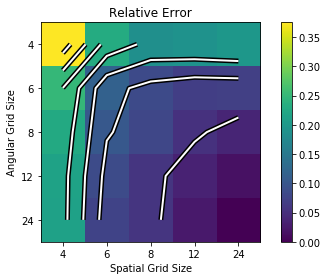

In [41]:
ax = plt.gca()
plt.contour(rel_err.T, colors='k', linewidths=5)
plt.contour(rel_err.T, colors='w', linewidths=2)
plt.imshow(rel_err.T)
ax.set_xticks(range(len(ns_list)))
ax.set_yticks(range(len(na_list)))
ax.set_xticklabels(ns_list)
ax.set_yticklabels(na_list)
plt.xlabel('Spatial Grid Size')
plt.ylabel('Angular Grid Size')
plt.title('Relative Error')
plt.colorbar()
plt.tight_layout()